In [1]:
import os
import torch
import psutil
from util import format
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import DeepLenseSuperresolutionDataset
import matplotlib.pyplot as plt 
from torchinfo import summary
from util import run_experiment_task2, MSE_Metric, PSNR_Metric, SSIM_Metric
import math

# PyTorch imports
import torch.nn as nn
import torch.nn.functional as F



class CONFIG:
    BATCH_SIZE = 4
    
    # limit the data to prototype faster
    DATA_LIMIT = 0
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task2B"
    DATA_PATH = os.path.join("Data", "Task2B")
    PORTION_OF_DATA_FOR_TRAINING = 0.8

In [2]:
memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 3.3GB


In [3]:
from tqdm import tqdm
import numpy as np
import random

class DeepLenseSuperresolutionDataset(Dataset):

    def __init__(self, folder_path : str,
                 randomize_dataset : bool = True,
                 preprocess_LR : bool = True, 
                 preprocess_HR : bool = True,
                 call_preprocess : bool = True,
                 data_limit=0, 
                 mean_LR = None, std_LR=None, 
                 mean_HR=None, std_HR=None,
                 task2=False) -> None:
        
        self.folder_path = folder_path
        self.class_folders = []
        self.preprocess_LR = preprocess_LR
        self.preprocess_HR = preprocess_HR

        folders = [os.path.join(self.folder_path, v) for v in os.listdir(folder_path)]

        self.LR = [v for v in folders if v.endswith("LR")][0]
        self.HR = [v for v in folders if v.endswith("HR")][0]

        self.class_folders = [self.LR, self.HR]
        
        print(self.LR, self.HR)
        print(len(os.listdir(self.LR)) == len(os.listdir(self.HR)) )
        assert len(os.listdir(self.LR)) != (os.listdir(self.HR)), "the number of samples in Low Resolution has to be the same as High Resolution"

        # get the samples 
        self.samples = os.listdir(self.LR)
        
        # limit the data (for faster prototyping )
        if data_limit > 0:
            self.samples = self.samples[:data_limit]
                
        # Datapoints
        self.LR_data = []
        self.HR_data = []
            
        pbar = tqdm(self.samples)
        for path in pbar:
            # load from the low resolution
            img1 = np.load(os.path.join(self.LR, path))
            self.LR_data.append(torch.Tensor(img1))            
            
            if task2:
            # load from the high resolution=
                img2 = np.load(os.path.join(self.HR, "HR_" + path[3:]))
            else:
                img2 = np.load(os.path.join(self.HR, path))
                

            self.HR_data.append(torch.Tensor(img2))
            
            pbar.set_description("Loading dataset : ")
        
        self.samples = np.array(self.samples)
        self.LR_data = torch.stack(self.LR_data)
        self.HR_data = torch.stack(self.HR_data)
        
        # calculate statistical values about the dataset 
        self.mean_HR = mean_HR
        if self.mean_HR is None:
            self.mean_HR = torch.mean(self.HR_data.reshape(-1))
            
        self.mean_LR = mean_LR
        if self.mean_LR is None:
            self.mean_LR = torch.mean(self.LR_data.reshape(-1))

        self.std_HR = std_HR
        if self.std_HR is None:
            self.std_HR = torch.std(self.HR_data.reshape(-1))

        self.std_LR = std_LR
        if self.std_LR is None:
            self.std_LR = torch.std(self.LR_data.reshape(-1))
            
        if call_preprocess:
            self.preprocess()            
        
        
        if randomize_dataset:
            self.randomize_dataset()

    def preprocess(self):
        
        pbar = tqdm(self.samples)
        
        for i, _ in enumerate(pbar):
            
            if self.preprocess_LR:
                self.LR_data[i] = self.preprocess_LR_func(self.LR_data[i])

            if self.preprocess_HR:
                self.HR_data[i] = self.preprocess_HR_func(self.HR_data[i])
            
            pbar.set_description("preprocessing :")
        
        
    # To override later (if any preprocessing is required)
    def preprocess_LR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        
    def preprocess_HR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        

    def randomize_dataset(self):
        idxes = np.arange(len(self.LR_data))
        random.shuffle(idxes)

        self.samples = self.samples[idxes]
        self.LR_data = self.LR_data[idxes]
        self.HR_data = self.HR_data[idxes]
    
    def preprocess_input(self, x : np.ndarray) -> torch.Tensor:
        return torch.tensor( (x - self.mean) / self.std).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.LR_data[idx], self.HR_data[idx]
    

In [4]:
dataset = DeepLenseSuperresolutionDataset(folder_path=CONFIG.DATA_PATH, 
                                          randomize_dataset=True,
                                          data_limit=CONFIG.DATA_LIMIT,
                                          task2=True)

# do train/val split
dataset_size = len(dataset)
train_size = int(dataset_size * CONFIG.PORTION_OF_DATA_FOR_TRAINING)
val_size = dataset_size - train_size

print(f"splitting into : {train_size} {val_size}")

# splitting dataset 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"sizes of datasets : len(train)={len(train_dataset)} len(val)={len(val_dataset)}")

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE)

Data/Task2B/LR Data/Task2B/HR
True


preprocessing :: 100%|██████████| 300/300 [00:00<00:00, 474.85it/s]


splitting into : 240 60
sizes of datasets : len(train)=240 len(val)=60


In [5]:
# get sample batch, useful for prototyping the architectures
x, y = next(iter(train_loader))

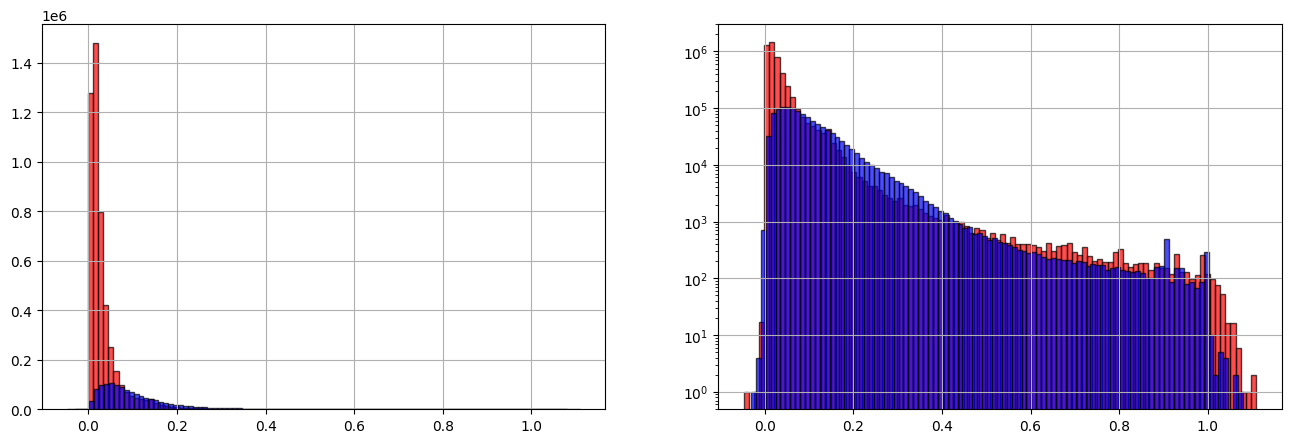

In [6]:
# sanity check 
a = 0.7
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.yscale("log")
plt.grid()
plt.show()


In [7]:
try:
    print(f"mean_LR = {dataset.mean_LR.item()} std_LR = {dataset.std_LR.item()}")
except Exception as e:
    print(f"mean_LR = {dataset.mean_LR} std_LR = {dataset.std_LR}")


try:
    print(f"mean_HR = {dataset.mean_HR.item()} std_HR = {dataset.std_HR.item()}")
except Exception as e:
    print(f"mean_HR = {dataset.mean_HR} std_HR = {dataset.std_HR}")
    

memory_after = psutil.virtual_memory()
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean_LR = 0.10496020317077637 std_LR = 0.09442389756441116
mean_HR = 0.03399568423628807 std_HR = 0.05555187165737152
RAM used : 3.35GB, RAM free : 3.37GB, memory used : 45.15MB


shape of x = torch.Size([4, 1, 64, 64]), y = torch.Size([4, 1, 128, 128])


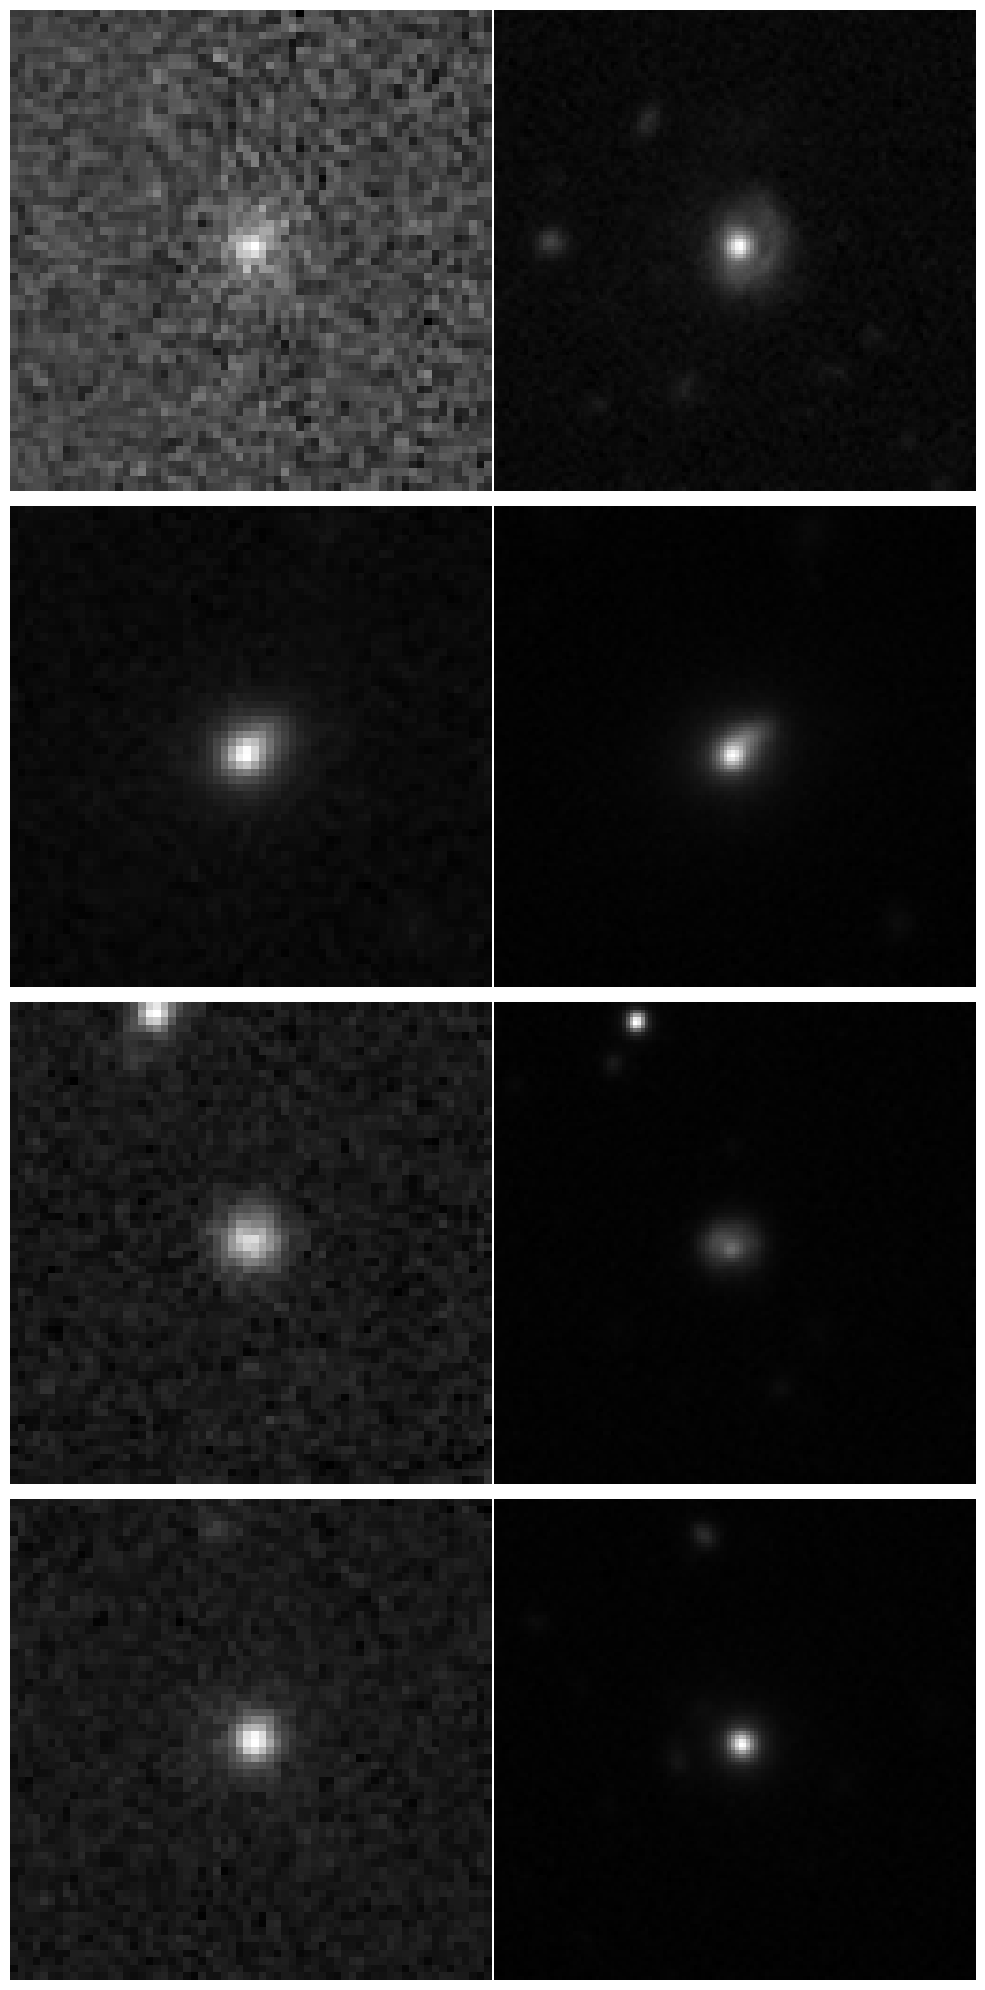

In [8]:
x, y = next(iter(val_loader))

print(f"shape of x = {x.shape}, y = {y.shape}")

plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

size_of_one = 5
fig, axes = plt.subplots(plot_size*plot_size, 2, figsize=(size_of_one * plot_size, size_of_one * len(x)))

for i, ax in enumerate(axes.flat):
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    if i % 2 == 0:
        img = x[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
    else:
        img = y[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
class SRCNN_upsampler(nn.Module):
    def __init__(self) -> None:
        super(SRCNN_upsampler, self).__init__()
        
        self.upsampler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)        
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )

        self.reconstruction = nn.Conv2d(64, 1, (5, 5), (1, 1), (2, 2))

        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.upsampler is not None:
            x = self.upsampler(x)
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

In [10]:
model  = SRCNN_upsampler()
model(x).shape
summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN_upsampler                          [4, 1, 128, 128]          --
├─Upsample: 1-1                          [4, 1, 128, 128]          --
├─Sequential: 1-2                        [4, 128, 128, 128]        --
│    └─Conv2d: 2-1                       [4, 128, 128, 128]        10,496
│    └─ReLU: 2-2                         [4, 128, 128, 128]        --
├─Sequential: 1-3                        [4, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [4, 64, 128, 128]         204,864
│    └─ReLU: 2-4                         [4, 64, 128, 128]         --
├─Conv2d: 1-4                            [4, 1, 128, 128]          1,601
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
Total mult-adds (G): 14.22
Input size (MB): 0.07
Forward/backward pass size (MB): 101.19
Params size (MB): 0.87
Estimated Total Size (MB): 102.12

In [11]:
run_experiment_task2(train_dataloader=train_loader, 
                     val_dataloader=val_loader, 
                     Model=SRCNN_upsampler, 
                     run_name="SRCNN_upsample", 
                     model_parameters={}, 
                     epochs=10,
                     learning_rate=1e-4, 
                     optimizer='adam',
                     savepath="models/srcnn_upsample.pth",
                     metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                     cfg=CONFIG,
                     loss="MSE",
                     base_lr=1e-4, 
                     test_params={"save_in_total" : 10},
                     max_lr=1e-3,
                     scheduler_en=False,
                     metric_keyword="val_PSNR",
                     lr_steps=len(dataset) // 2,
                     start_with_test=True,
                     WANDB_ON=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


examples seen so far : 240 Mean Squared Error (MSE)=0.004236713516726606 ; PSNR=25.423646722634917 ; SSIM=0.2818544254409077 ; : 100%|██████████| 60/60 [00:01<00:00, 44.13it/s] 
examples seen so far : 60 Mean Squared Error (MSE)=0.004478316284495138 ; PSNR=25.10477296097734 ; SSIM=0.26205409913714994 ; : 100%|██████████| 15/15 [00:00<00:00, 34.27it/s] 
EPOCH : 0, average loss : 0.002083839154026161: 100%|██████████| 60/60 [00:02<00:00, 27.60it/s] 
examples seen so far : 240 Mean Squared Error (MSE)=0.0017119124626729122 ; PSNR=30.100440748840438 ; SSIM=0.7796899053778609 ; : 100%|██████████| 60/60 [00:00<00:00, 64.52it/s]
examples seen so far : 60 Mean Squared Error (MSE)=0.0013503498832845146 ; PSNR=30.110094622343624 ; SSIM=0.7843739607576596 ; : 100%|██████████| 15/15 [00:00<00:00, 48.11it/s]
EPOCH : 1, average loss : 0.0016538900929541948: 100%|██████████| 60/60 [00:00<00:00, 66.34it/s]
examples seen so far : 240 Mean Squared Error (MSE)=0.0014470779655060915 ; PSNR=31.767312397050

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▄▃▃▂▂▂▁▁▂
train_Mean Squared Error (MSE),█▂▁▁▂▁▂▁▁▁▁
train_PSNR,▁▅▆▇▆▇▆████
train_SSIM,▁▇██▇██████
val_Mean Squared Error (MSE),█▂▁▁▂▁▂▁▁▁▁
val_PSNR,▁▅▆▇▆▇▆████
val_SSIM,▁▇██▇██████
loss,0.00135
train_Mean Squared Error (MSE),0.00125
train_PSNR,33.73435
train_SSIM,0.83598
